# Wifi propagation
## Project for the minicourse: Advanced Finite Element Methods in Python
## Noemi Maggiotto & Alberto Tirapelle

# Introduction
We are given the following problem: there is a rectangular flat which contains a wifi router, and our aim is to analyze how to the electomagnetic waves propagate in the rooms. In particular we are interested in the behaviour of the electromagnetic waves through the walls which, in part absorb them and in part reflect them. 

In practice, we solve the following equation (Helmholtz equation, which is a particular case of the Maxwell equations), through finite elements method:
$$\Delta E + \frac{k^2}{n^2}E = 0$$

Where $E$  (unknown) is the electrical field, $k$ (constant) is the angular wavenumber of the wifi signal, and $n$ (function) is the refractive index of the material in which the wave is ($n=1$ in the air).
For us $n$ is a complex number, where the real part is related to the reflexion of the wall and the imaginary part is related to the absorption of the wall.

The wifi router is simulated by a simple circle, and it is the Dirichlet boundary condition such that $E = C$ constant.


In [1]:
# Import packages
import numpy as np
import meshio
import random
import matplotlib.pyplot as plt
import scipy.sparse as sps
import matplotlib.tri as tri
import myfavfunctions as mff

First of all, we import the mesh of our 2D domain (the plan of the flat), which is a Delaunay triangulation.

In [2]:
# We import the mesh 
mesh = meshio.read('./91project/wifi1.vtu')

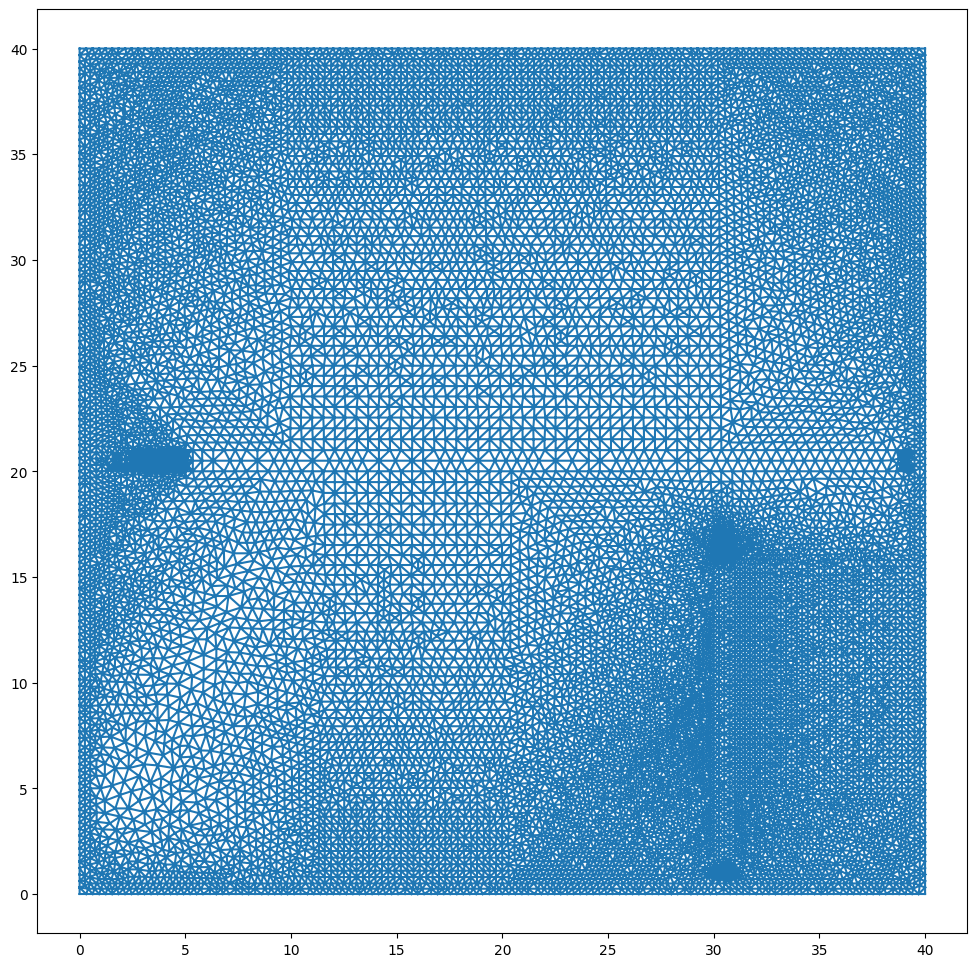

In [3]:
# We plot the mesh
%matplotlib inline
plt.rcParams["figure.figsize"] = 12, 12
fig = plt.figure()
ax  = fig.gca()
ax.axis('equal')
plt.triplot( mesh.points[:,0], mesh.points[:,1], triangles = mesh.cells[0].data )
plt.show()

Here we build some fundamental objects for our FEM analysis.
Calling $N_v$ the number of vertices of the mesh and $N_c$ the number of triangles of the mesh, we call:

_Points_ is the $(N_v \times 2)$-matrix that cointans the coordinates of the vertices of the triangles (in every row there are the two coordinates of a point of the mesh)

_Clist_ is the $(N_c \times 3)$-matrix that contains the vertices of the triangles (in every row there are the three indices of the vertices of a triangle of the mesh)

_B_ is a tensor, and it is related to the push forward operator that allow us to pass from the reference elements to the physical ones. Our reference element is the triangle with vertices $(0,0), (1,0), (0,1)$.

In [4]:
Points = mesh.points[:,:2]     # matrix with the coordinates of the vertices of the triangles
CList  = mesh.cells[0].data    # matrix that cointans the vertices of the triangles

# there are more triangles than vertices (2D)
Nv     = Points.shape[0]
Nc     =  CList.shape[0]

# the dimension of the element is 2
d_elem =  CList.shape[1] - 1
B   = ( Points[CList[:,1:]] - Points[CList[:,0]][:,None,:] ).transpose( ( 0,2,1 ) ) 
dtB = np.linalg.det( B )
iB  = np.linalg.inv( B )
iBt = iB.transpose( (0,2,1) )

print('Points:', Points.shape)
print('CList:', CList.shape)
print('B:', B.shape)
print('The number of vertices is Nv:', Nv)
print('The number of triangles is Nc:', Nc)
print('d_elem =', d_elem) 

Points: (16890, 2)
CList: (33258, 3)
B: (33258, 2, 2)
The number of vertices is Nv: 16890
The number of triangles is Nc: 33258
d_elem = 2


Now we model our wifi router as a circle with center _circle_center_ $= (2;5)$ and radius _circle_radius_ $= 1$. 

We also define two small numbers, _eps_ and _epsilon_, to better manage the mesh numerically.

In [5]:
# position of the wifi router
circle_center = np.array([2, 5])
circle_radius = 1

eps = 1e-5       # small number for the definition of walls and wifi router
epsilon = 1e-10  # small number for the search of the triangles

In order to define the function $n$ that appears in our equation, we need to define firstly the function _wall_, which returns a vector long as the number of points of the mesh, and for each point the entry is $0$ if it is not in a wall, $1$ if it is.

Then we call _wall_points_ the vector given by the function _wall_, and _wall_triangles_ the vector (long as the number of triangles) that tells us if a triangle is entirely contained in a wall (that is, its three vertices are $1$).

Moreover, we call _Dir_ the points of the circle (wifi router) where we will set the Dirichlet boundary condition.


In [6]:
def wall(Points, eps):
    
    res =       (Points[:,1] <= 0.5 + eps)  # down border
    res = res + (Points[:,0] >= 39.5 - eps) # right border
    res = res + (Points[:,0] <= 0.5 + eps)  # left border
    res = res + (Points[:,1] >= 39.5 - eps) # up border
    res = res + (Points[:,0] >= 5 - eps)  * ( Points[:,0] <= 39 + eps) * ( Points[:,1] >= 20 - eps) * ( Points[:,1] <= 21 + eps) # horizontal wall
    res = res + (Points[:,0] >= 30 - eps) * ( Points[:,0] <= 31 + eps) * ( Points[:,1] >= 1 - eps)  * ( Points[:,1] <= 15 + eps) # vertical wall
    
    return res

In [7]:
# We find the points and the triangles which are in a wall
wall_points    = wall(Points, eps)                        # vector long as the number of points
wall_triangles = np.all(wall_points[CList], axis=1)       # vector long as the number of triangles


# We find the points where to set the Dirichlet boundary condition, that are the points of the circle (circumference and interior)
distances = np.sqrt((Points[:, 0] - circle_center[0])**2 + (Points[:, 1] - circle_center[1])**2)
Dir_bool = (distances < circle_radius + eps)    # * (distances > circle_radius - eps) # to have just the circumference
Dir_int = Dir_bool.astype(int)
Dir = np.where(Dir_int == 1)[0] # points of the circle


#print('Dirichlet points: ', Dir_int)
print('Number of Dirichlet points: ', sum(Dir_int))
print('Indices of Dirichlet points:', Dir)

Number of Dirichlet points:  14
Indices of Dirichlet points: [5849 5850 5851 6069 6070 6071 6072 6075 6310 6311 6312 6314 6570 6571]


Here we plot the walls of the flat in blue and the circle (wifi router) in red

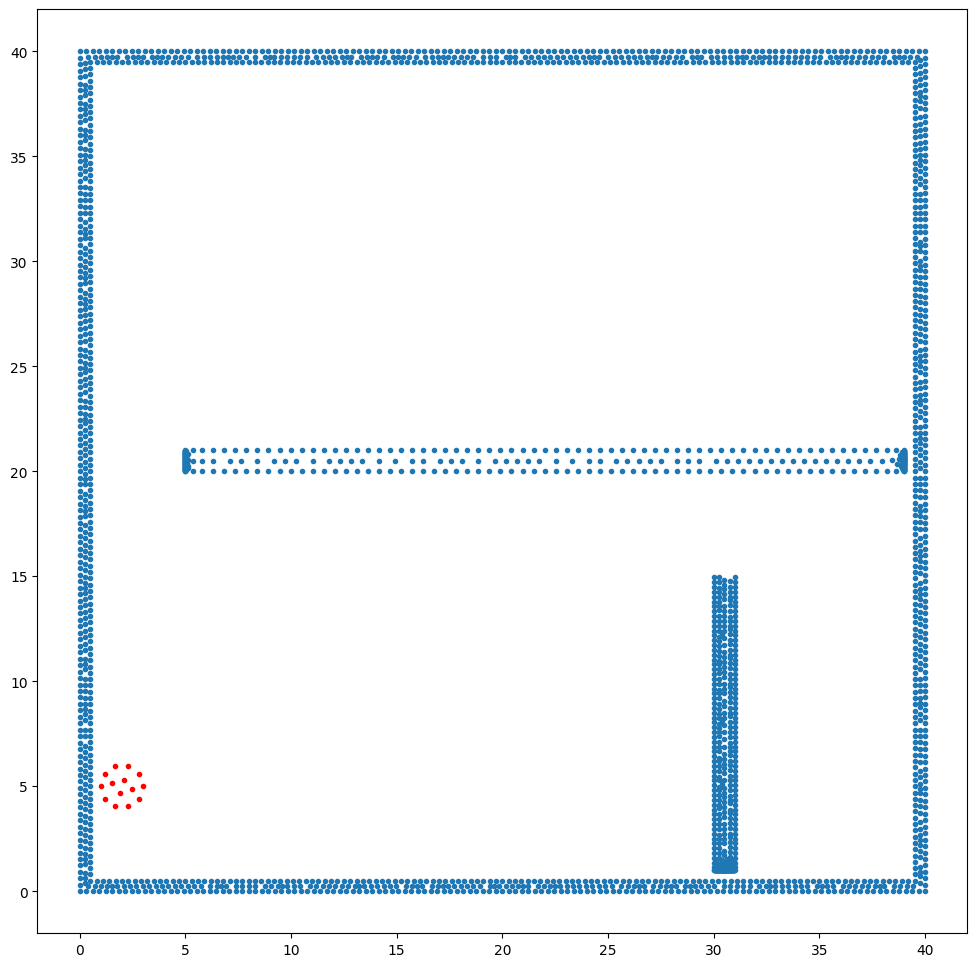

In [8]:
# We plot the walls of the flat in blue and the circle (wifi router) in red
plt.plot( Points[wall_points,0], Points[wall_points,1], '.')
plt.plot( Points[Dir_bool,0], Points[Dir_bool,1], '.', color='red')

We set $k=6$; and $n = 1+($_wall_ref_$+$_wall_abs_$)$, where $1+$_wall_ref_ and _wall_abs_ are respectively the real and the complex parts of $n$ (chosen as random numbers). We recall that $n=1$ out of the walls (air), while in the walls its real part is related to the reflexion of the signal due to the wall and its imaginary part is related to the absorption due to the wall.

We call _n_triangles_ the complex vector that for every triangle of the mesh it has entry equal to $1+($_wall_ref_$+$_wall_abs_$)$, recalling that a triangle is in a wall if all of its three vertices are. So our function $n$ is piecewise constant on the mesh.

In [9]:
k = 6

wall_ref = np.random.rand(1)
wall_abs = np.random.rand(1) * 0.5j

# vector that for every vertex of the mesh is 1 if the point is out of the walls, otherwise is complex
# n_points = (1+(wall_ref+wall_abs) * wall_points.astype(int))

# vector that for every triangle of the mesh is 1 if the triangle is out of the walls, otherwise is complex
n_triangles = (1+(wall_ref+wall_abs) * wall_triangles.astype(int))

We define the function _which_triangle_, which will be very useful.
This function requires in input the coordinates of a generic point _X_ of the domain;
then returns the triangle of the mesh where the point _X_ is contained and the coordinates of _X_ in the correspective reference element .

The coordinates of _X_ in the reference element, _X_ref_, are found via the pull back operator.
Actually, firstly we find the coordinates of _X_ with respect to every triangle transformed in its correspective reference element, and this ($N_c \times 2)-$matrix we call _X_ref_ .
Then we find the only triangle that contains _X_, checking wheter the coordinates of _X_ref_ are inside the reference element.
So we have the vector _cond_ that tells us in which component of _X_ref_ we have to look and hence in which triangle _X_ is.

In [10]:
def which_triangle( Points, CList, X, epsilon ):
    
    p1 = Points[CList[:,0]]  # coordinates of the vertex p1 for all the triangles
    #p2 = Points[CList[:,1]] # coordinates of the vertex p2 for all the triangles
    #p3 = Points[CList[:,2]] # coordinates of the vertex p3 for all the triangles

    X_ref = iB @ np.array(X - p1)[:, :, np.newaxis]   # pullback
    X_ref = X_ref.squeeze(-1)                         # X_ref is X in the coordinates of every element

    # condition to see if X_ref is inside a triangle
    cond = (X_ref[:,0]>=-epsilon) * (X_ref[:,1]>=-epsilon) * (( X_ref[:,0] + X_ref[:,1] )<=1+epsilon) 

    print('Coordinates of X in the reference element: ')
    print( X_ref[cond])
    print('Number of triangles containing X: ', sum(cond))
    print('Index of the triangle containing X: ', np.where(cond)[0])
    print('Coordinates of the vertices of the triangle containing X: ')
    print( Points[CList[cond]] )
    print( 'Indices of the vertices of the triangle containing X: ')
    print( CList[cond])
    print('Value of the function wall on the three vertices: ',wall_points[CList[cond]][0])
    print('')
    
    return X_ref, cond

Here we define the function _n_evaluate_point_, which for a generic point X of the domain returns the value of $n$ (we recall that $n$ is piecewise constant on the mesh). This is just an example to better understand how the function _which_triangle_ can be used. (Here we use again the fact that a triangle is in a wall if all of its three vertices are).

In [11]:
def n_evaluate_point( Points, CList, wall_points, wall_ref, wall_abs, X, epsilon ):

    _, cond = which_triangle( Points, CList, X, epsilon )
    
    if all( wall_points[CList[cond]][0] ):
        n_evaluate_point = ( 1 + (wall_ref + wall_abs)*1 )
        
    else:
        n_evaluate_point = ( 1 + (wall_ref + wall_abs)*0 )

    return n_evaluate_point

In [12]:
#X = np.array([2.3,5.3])
X = np.array([random.uniform(0, 40), random.uniform(0, 40)])

print( 'The value of n in the point ', X, 'is: ', n_evaluate_point( Points, CList, wall_points, wall_ref, wall_abs, X, epsilon ) )

Coordinates of X in the reference element: 
[[0.22291671 0.69426997]]
Number of triangles containing X:  1
Index of the triangle containing X:  [24500]
Coordinates of the vertices of the triangle containing X: 
[[[37.796722 31.58561 ]
  [37.60311  31.805695]
  [37.452675 31.373741]]]
Indices of the vertices of the triangle containing X: 
[[11232 11220 10982]]
Value of the function wall on the three vertices:  [False False False]

The value of n in the point  [37.51470137 31.4875763 ] is:  [1.+0.j]


# FEM analysis
The problem we want to solve is the following: 
$$
\begin{cases}
\Delta E + \frac{k^2}{n^2}E &= 0, \quad \text{in $\Omega$} \\
       E &= C, \quad \text{in $\partial\Omega$} 
\end{cases}
$$
where $\Omega \subset \mathbb{R}^2$ is the domain (2D plant of the flat) and $\partial\Omega$ is its boundary, $\quad k \in \mathbb{R}$, $ \quad n: \Omega\rightarrow \mathbb{C}$,  $\quad E: \Omega\rightarrow \mathbb{C}$, $\quad C \in \mathbb{C}$.

Now we find its weak formulation in order to implement the finite element method.

We recall that $H^1(\Omega) = \{v \in L^2(\Omega) : \partial_x v, \partial_yv \in L^2(\Omega) \} $ and $H^1_0(\Omega) = \{ v \in H^1(\Omega) : Tv=0 \}$, where $T$ the trace operator, which is the unique linear bounded operator $T: H^1(\Omega) \rightarrow L^2(\partial \Omega)$ such that $Tv=v|_{\partial \Omega}$ if $v \in H^1(\Omega) \cap C(\bar{\Omega}).$ We need to deal with the trace operator, because in dimension 2 a function in $H^1(\Omega)$ does not have necessarily a continuous representative and hence cannot be 'evaluated' on $\partial \Omega$.


Firstly, we multiply the equation for a test function $v \in H^1_0(\Omega) $ and we integrate over the domain $\Omega$:
$$  
\displaystyle \int_{\Omega} \Delta E v + \displaystyle \int_{\Omega} \frac{k^2}{n^2} E v = 0
$$

Integrating by parts the first term we obtain:
$$  
\displaystyle \int_{\partial\Omega}  v \nabla E \cdot \hat{n} - \displaystyle \int_{\Omega} \nabla E \cdot \nabla v + \displaystyle  \int_{\Omega} \frac{k^2}{n^2} E v = 0
$$

And since $v \in H^1_0(\Omega) $, we have that $T v = 0$  and so the first term is zero.

So the weak formulation is the following:

Find the solution $E \in H^1(\Omega) $ such that for every test function $v \in H^1_0(\Omega) $ it holds:
$$ 
\begin{cases}
- \displaystyle \int_{\Omega} \nabla E \cdot \nabla v +  \displaystyle \int_{\Omega} \frac{k^2}{n^2} E v &= 0 \quad \text{in $\Omega$} \\
       TE &= C
\end{cases}
$$


Now we consider the space $X_h = \bigl\{v_h \in H^1(\Omega) \,:\,  v_h \text{ is a piecewise linear polynomial defined on the mesh} \bigl\}$.
So the functions in $X_h$ are continuos.

$X_h$ is a finite dimensional subspace of $H^1(\Omega)$, and we choose as a basis the hat functions $ \{ \phi_i \}_{i=1, \ldots, N_v}$ defined as:

$$  \phi_i (p_j) = \delta_{ij} \quad \text{for} \quad i,j = 1, \ldots, N_v$$
where $p_j$ is the $j^{th}$ vertex of the mesh and $N_v$ is the number of vertices of the mesh.

An element $v_h \in X_h$ can be written uniquely as linear combination of the basis functions in this way:
$$ v_h(x)= \sum^{N_v}_{i = 1} v_i \phi_i(x)$$
where $v_i = v_h(x_i)$ by properties of the hat functions (the coefficients have physical meaning).

It is important to note that, having fixed the basis, there is an univoque identification between a function $v_h \in X_h$ and the vector of its coefficients $v_h \in \mathbb{R}^n$.

Now, following the Galerkin approach, we pass from the weak formulation defined on an infinite dimensional space, to the one defined on an finite dimensional space:

Find $E_h \in X_h $ such that $\forall v_h \in X_h $ with $v_h|_{\partial \Omega}=0$ it holds:
$$ 
\begin{cases}
- \displaystyle \int_{\Omega} \nabla E_h \cdot \nabla v_h +  \displaystyle \int_{\Omega} \frac{k^2}{n^2} E_h v_h &= 0 \\
       E_h(p) &= C \qquad \text{for every Dirichlet vertex } p 
\end{cases}
$$

Instead of looking at every $v_h $, we just consider the basis functions, obtaining a system of $N_v$ equations:

Find $E_h \in X_h $ such that it holds:
$$ 
\begin{cases}
- \displaystyle \int_{\Omega} \nabla E_h \cdot \nabla \phi_j +  \displaystyle \int_{\Omega} \frac{k^2}{n^2} E_h \phi_j &= 0 \quad \forall j \in Ind\\
       E_h(p_j) &= C \quad \forall j \in Dir
\end{cases}
$$
where $Dir$ is the set of the vertices where we will set the Dirichlet bounday condition (the circle where the wifi router is positioned), and $Ind$ is the set of all the other vertices.

In particular, the approximation in $X_h$ of the solution $E$ can be written as: 
$$ E_h(x)= \sum^{N_v}_{i = 1} E_i \phi_i(x) = \sum_{i \in Ind} E_i \phi_i(x) + \sum_{i \in Dir} E_i \phi_i(x)$$


Substituting the latter expression in the weak formulation we obtain:

$$  - \int_{\Omega} \nabla \left( \sum^{N_v}_{i = 1} E_i \phi_i \right) \cdot \nabla \phi_j + \int_{\Omega} \frac{k^2}{n^2} \left( \sum^{N_v}_{i = 1} E_i \phi_i \right) \phi_j = 0  $$

$$ \sum_{i = 1}^{N_v} \left( - \int_{\Omega} \nabla \phi_i \cdot \nabla \phi_j + \int_{\Omega} \frac{k^2}{n^2} \phi_i \phi_j \right) E_i = 0 $$

$$ 
  \sum_{i \in Ind} \left( - \int_{\Omega} \nabla \phi_i \cdot \nabla \phi_j + \int_{\Omega} \frac{k^2}{n^2} \phi_i \phi_j \right) E_i =
- \sum_{i \in Dir} \left( - \int_{\Omega} \nabla \phi_i \cdot \nabla \phi_j + \int_{\Omega} \frac{k^2}{n^2} \phi_i \phi_j \right) C
$$

Let's call $S_{ij} = \int_{\Omega} \nabla \phi_i \cdot \nabla \phi_j$ the stiffness matrix,
           $M_{ij} = \int_{\Omega} \frac{k^2}{n^2} \phi_i \phi_j$ the mass matrix,
           and the load vector $f$ is the right hand side of the equation that is the zero vector.

We know that $S$ and $ (\int_{\Omega} \phi_i \phi_j)_{ij} $ are real, sparse, banded, symmetric and positive definite, but in the current problem our mass matrix is slightly modified and we will take care of this during its assembly.

To set the Dirichlet boundary condition we use a so called 'très grand valeur' (or penalisation method).
In this way we are able to impose $E_h(p_i) = C \quad \forall i \in Dir$ and to keep the simmetry of the matrix of the FEM system.
In few words, we multiply the diagonal entries corresponding to $Dir$ of our system matrix $(M+S)$ by a big number, say $tgv$, and we modify the entries corresponding to $Dir$ of the load vector $f$ with $C \cdot tgv$.
We call these new objects $\widetilde{(M+S)}$ and $\tilde{f}$.

So we have to solve the following FEM system: $\widetilde{(M+S)} E = \tilde{f}$.

We recall that the solution of the system $E$ is the complex vector that contains the value of the approximation of the solution in each vertex of the mesh.

In [22]:
# phi_i evaluated in the reference point x, i=1,2,...
def phi( d,x ):
    # basis function
    return np.eye( d + 1, 1 ).reshape(-1) + x @ gradphi( d,x )
    
# grad phi_i evaluated in the reference point x, i=1,2,...
def gradphi( d,x ):
    # gradient of the basis function
    return np.hstack( ( - np.ones( ( d,1 ) ), np.eye( d ) ) )

To assemble the mass matrix $M_{ij} = \int_{\Omega} \frac{k^2}{n^2} \phi_i \phi_j$ :

We initialize to zero a $(N_c \times 3 \times 3)-$complex tensor and we will obtain a $(N_v\times N_v)-$complex matrix in the csr sparse format.

Let's consider a physical element, say $K$. Firstly we need to compute the following $(3 \times 3)-$matrix associated to $K$:

\begin{pmatrix}
\int_{K} \phi_i \phi_i & \int_{K} \phi_i \phi_j & \int_{K} \phi_i \phi_k \\
\int_{K} \phi_j \phi_i & \int_{K} \phi_j \phi_j & \int_{K} \phi_j \phi_k \\
\int_{K} \phi_k \phi_i & \int_{K} \phi_k \phi_j & \int_{K} \phi_k \phi_k \\
\end{pmatrix}

where $\phi_i, \phi_j, \phi_k$ are the three hat functions defined on the element $K$.

In order to do this, we consider the reference element and we apply quadrature 
(in our case, we need to add the contribution given by:  _k$^2$ / n_triangles$^2$_).
Then, we pass from the reference element to the physical ones by a transformation (using the determinant of _B_), and in the end the matrix is assembled.

In [23]:
# for us M = int (k^2/n^2 phi_i phi_j)

def mass_assembly( Points, CList, dtB):
    
    Nv     = Points.shape[0]
    Nc     =  CList.shape[0]
    d_elem =  CList.shape[1] - 1

    i = np.kron( np.ones( ( 1,CList.shape[1] ), dtype = 'int64' ), CList ).reshape(-1,order='F')
    j = np.kron( CList, np.ones( ( 1,CList.shape[1] ), dtype = 'int64' ) ).reshape(-1,order='F')

    X, W = mff.simplexQuadrature( 2, d_elem )
    mass = np.zeros( ( Nc, CList.shape[1], CList.shape[1] ), dtype=complex ) # Nc x 3 x 3 tensor
    for q in range( W.shape[0] ):
        
        N0 = phi( d_elem, X[q,:][None,:] )
        
        kovernsquared = k**2 / n_triangles**2 # array long as the number of triangles
        
        mass = mass + ( N0.T @ N0 ) * ( kovernsquared * dtB * W[q] )[:,None,None]
        
    M = sps.csr_matrix( ( mass.reshape(-1,order='F'), ( i, j ) ), shape = ( Nv, Nv ), dtype=np.complex128 )

    return M

To assemble the stiffness matrix $S_{ij} = \int_{\Omega} \nabla \phi_i \cdot \nabla \phi_j$ :

We initialize to zero a $(N_c \times 3 \times 3)-$complex tensor and we will obtain a $(N_v\times N_v)-$complex matrix in the csr sparse format.

Let's consider a physical element, say $K$. Firstly we need to compute the following $(3 \times 3)-$matrix associated to $K$:

\begin{pmatrix}
\int_{K} \nabla \phi_i \cdot\nabla\phi_i & \int_{K} \nabla\phi_i \cdot\nabla\phi_j & \int_{K} \nabla\phi_i \cdot\nabla\phi_k \\
\int_{K} \nabla\phi_j \cdot\nabla\phi_i & \int_{K} \nabla\phi_j \cdot\nabla\phi_j & \int_{K} \nabla\phi_j\cdot \nabla\phi_k \\
\int_{K} \nabla\phi_k \cdot\nabla\phi_i & \int_{K} \nabla\phi_k \cdot\nabla\phi_j & \int_{K} \nabla\phi_k \cdot\nabla\phi_k \\
\end{pmatrix}

where $\phi_i, \phi_j, \phi_k$ are the three hat functions defined on the element $K$.

Since we are dealing with hat functions, that are piecewise linear, their gradient evaluated on any point of the reference element will be:
\begin{pmatrix}
-1 & 1 & 0 \\
-1 & 0 & 1 \\
\end{pmatrix}


As for our mass matrix, we consider the reference element and we apply quadrature.
Then, we pass from the reference element to the physical ones by pushing forward the gradient of the hat functions and by using the determinant of B, and in the end the matrix is assembled.

In [24]:
def stiff_assembly( Points, CList, dtB, iBt, sigma = None ):
    
    Nv     = Points.shape[0]
    Nc     =  CList.shape[0]
    d_elem =  CList.shape[1] - 1

    i = np.kron( np.ones( ( 1,CList.shape[1] ), dtype = 'int64' ), CList ).reshape(-1,order='F')
    j = np.kron( CList, np.ones( ( 1,CList.shape[1] ), dtype = 'int64' ) ).reshape(-1,order='F')
    
    if np.logical_not( bool( sigma ) ):
        sigma = np.stack( Nc * tuple( np.eye(d_elem)[None,:,:] ), axis = 0 )
        
    X, W = mff.simplexQuadrature( 1, d_elem )
    stiff = np.zeros( ( Nc, CList.shape[1], CList.shape[1] ), dtype=complex )
    for q in range( W.shape[0] ):
        N1 = iBt @ gradphi( d_elem, X[q,:][None,:] )
        stiff = stiff - ( N1.transpose(0,2,1) @ (sigma @ N1) ) * ( dtB * W[q] )[:,None,None]
    S = sps.csr_matrix( ( stiff.reshape(-1,order='F'), ( i, j ) ), shape = ( Nv, Nv ), dtype=np.complex128 )
    
    return S

In [31]:
M = mass_assembly ( Points, CList, dtB )

plt.rcParams["figure.figsize"] = 5, 5
print('M:', M.shape)
#plt.spy( M, precision = 'present' )

M: (16890, 16890)


In [32]:
S = stiff_assembly( Points, CList, dtB, iBt )
print('S:', S.shape)
#plt.spy( S, precision = 'present' )

S: (16890, 16890)


Now we define our FEM system, setting the Dirichlet boundary conditions. 

We implement the penalisation method (using $C=5$), remarking the fact that for modifying the sparse matrix of the system it is convenient to pass for one moment from the csr format to the coo format.

We plot the sparsity pattern of the matrix.

We solve the system by the command _scipy.sparse.linalg.spsolve_ which is based on LU factorization and is efficient for sparse systems.

Text(0.5, 1.0, 'Sparity pattern of the matrix')

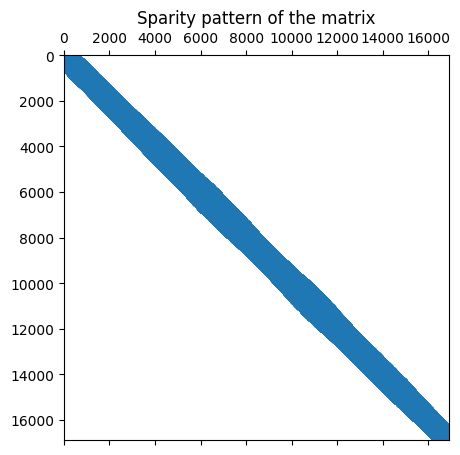

In [34]:
tgv = 10**14
C = 5+0j # value of E in the Dirichlet vertices

# in principle M and S are symmetric
# in M and S, I could set the Dir rows to 0 and put 1 on the diagonal but I would lose the symmetry
# instead we add the tgv on the diagonal at the positions corresponding to Dir
sys = M + S
f = np.zeros(Points.shape[0], dtype = complex)

sys_tgv      = sys.copy()
sys_tgv      = sys_tgv.tocoo()
sys_tgv.row  = np.append( sys_tgv.row, Dir )
sys_tgv.col  = np.append( sys_tgv.col, Dir )
sys_tgv.data = np.append( sys_tgv.data, np.ones_like( Dir ) * tgv )
sys_tgv      = sys_tgv.tocsr()

f_tgv = f.copy()
f_tgv[ Dir ] = C * np.ones_like( Dir ) * tgv

plt.spy( sys_tgv, precision = 'present' )
plt.title('Sparity pattern of the matrix')

In [28]:
# Solving the FEM linear system
E = sps.linalg.spsolve( sys_tgv, f_tgv )

Here we plot the signal power, defined as $S = \log(E\overline{E})$, noting that $E \in \mathbb{C}$ and $S \in \mathbb{R}$ . From the plot it is easy to see that $S$ is higher where the wifi router is positioned and it is possible to recognise where the walls are: indeed the signal power becomes lower through them.

Text(0.5, 1.0, 'Plot of the signal power S')

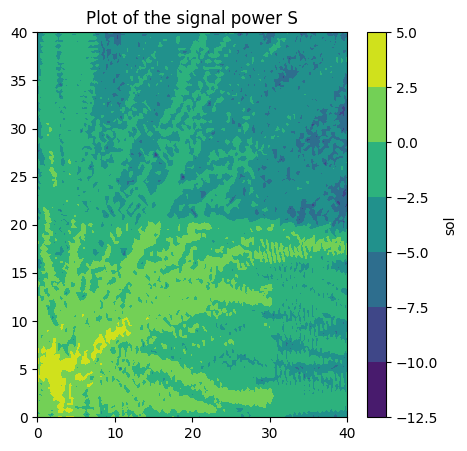

In [29]:
# Signal power S
S = np.log( np.real(E*np.conjugate(E)) ) # s is not really complex so i take the real part

triang = tri.Triangulation(Points[:,0], Points[:,1], CList)
plt.figure(figsize=(5,5))
plt.tricontourf(triang, S)
plt.colorbar(label ='sol')
plt.title('Plot of the signal power S')

Here we compute the piecewise linear approximation of the solution $E$. We achieve this by defining the function _E_linapprox_, which allow us to evaluate $E$ in any point $X$ of the domain. 

We recall that $ E_h(x)= \sum^{N_v}_{i = 1} E_i \phi_i(x) \quad \forall x \in \Omega $.
In particular $E_h(x)$ is the linear combination of the three hat functions defined on the triangle containing $x$, because the other terms of the sum are zero.

So first, we find which is the triangle that contains $X$ by using our function _which_triangle_.
Then we evaluate the three hat functions at the point $X$ considered in the coordinates of the reference element.
Finally, we perform the linear combination of the values of the solution at the vertices and the evaluations of the hat functions mentioned above.

In [48]:
def E_linapprox (E, CList, Points, X, epsilon):

    X_ref, cond = which_triangle( Points, CList, X, epsilon )

    phi_evaluated = phi(2, X_ref[cond])              # valutazione di phi_i(X_ref) per i=1,2,3

    E1, E2, E3 = E[ CList[cond][0] ]                 # valutazioni di E nei vertici del triangolo 
    
    E_approx = E1 * phi_evaluated[0][0] + E2 * phi_evaluated[0][1] + E3 * phi_evaluated[0][2]
    
    return E_approx

In [53]:
print('Norma 2 di E:', np.linalg.norm( E, 2 ))
print('Norma Inf di E:', np.linalg.norm( E, np.inf ))
print('')

#X = Points[random.randint(0,len(Points)),:] # testo su un vertice
#X = np.array([2, 5.2])
X = np.array([random.uniform(0, 40), random.uniform(0, 40)])

print('L approssimazione lineare di E in', X ,' è:', E_linapprox(E, CList, Points, X, epsilon) )

Norma 2 di E: 135.40326135282345
Norma Inf di E: 10.037175435477167

Coordinates of X in the reference element: 
[[0.48981918 0.377994  ]]
Number of triangles containing X:  1
Index of the triangle containing X:  [20586]
Coordinates of the vertices of the triangle containing X: 
[[[36.05173  14.826559]
  [36.05173  15.098296]
  [35.78025  15.090289]]]
Indices of the vertices of the triangle containing X: 
[[3167 3308 3307]]
Value of the function wall on the three vertices:  [False False False]

L approssimazione lineare di E in [35.94911309 15.05934949]  è: (0.33633824263456347+0.4754701571459117j)


In [26]:
# PETSc
from petsc4py import PETSc
import time

ModuleNotFoundError: No module named 'petsc'

In [ ]:
# sys_tgv e f_tgv sono complessi

solver_parameters = {
            "iterativeSolver"       : 'gmres',
            "preconditioner"        : 'ilu', # 'gamg' visit https://petsc.org/main/manualpages/PC/
            "relativeTolerance"     : 1e-8,
            "absoluteTolerance"     : 1e-8,
            "maximumIterations"     : 1e+2,
            "setInitialGuessNonzero": False,
            }


# build PETSc context
A = PETSc.Mat().createAIJ(size=(Nv, Nv), csr=(sys_tgv.indptr, sys_tgv.indices, -sys_tgv.data), comm=PETSc.COMM_WORLD)
A.setType(PETSc.Mat.Type.AIJ)
A.setUp()

wifi_propag = PETSc.KSP().create() # creating a KSP object
wifi_propag.setOperators( A )
wifi_propag.setType(                solver_parameters["iterativeSolver"       ] ) 
wifi_propag.getPC().setType(        solver_parameters["preconditioner"        ] ) 
wifi_propag.setTolerances( rtol   = solver_parameters["relativeTolerance"     ], \
                           atol   = solver_parameters["absoluteTolerance"     ], \
                           max_it = solver_parameters["maximumIterations"     ] )
wifi_propag.setInitialGuessNonzero( solver_parameters["setInitialGuessNonzero"] )
wifi_propag.setConvergenceHistory()

# initialize PETSc solution vector
solution = PETSc.Vec().createSeq(Nv, comm=PETSc.COMM_WORLD)
solution.setFromOptions()

# initialize PETSc     rhs vector
righthandside = PETSc.Vec().createSeq(Nv, comm=PETSc.COMM_WORLD)
righthandside.setFromOptions()
righthandside.setValues(range(Nv), f_tgv)



t = time.time()
wifi_propag.solve( righthandside, solution ) # A is implicit inside the context
print('Elapsed time %1.3f seconds.' % (time.time() - t))
sol_petsc = solution.getArray()


np.linalg.norm( E - sol_petsc ) / np.linalg.norm( E )
residuals = wifi_propag.getConvergenceHistory()
plt.semilogy(residuals)

In [48]:
# sys_tgv e f_tgv sono complessi

solver_parameters = {
            "iterativeSolver"       : 'gmres',
            "preconditioner"        : 'ilu', # 'gamg' visit https://petsc.org/main/manualpages/PC/
            "relativeTolerance"     : 1e-8,
            "absoluteTolerance"     : 1e-8,
            "maximumIterations"     : 1e+2,
            "setInitialGuessNonzero": False,
            }


# build PETSc context
A = PETSc.Mat().createAIJ( size = ( Nv, Nv ), csr = ( sys_tgv.indptr, sys_tgv.indices, - sys_tgv.data ) )
wifi_propag = PETSc.KSP().create() # creating a KSP object
wifi_propag.setOperators( A )
wifi_propag.setType(                solver_parameters["iterativeSolver"       ] ) 
wifi_propag.getPC().setType(        solver_parameters["preconditioner"        ] ) 
wifi_propag.setTolerances( rtol   = solver_parameters["relativeTolerance"     ], \
                                atol   = solver_parameters["absoluteTolerance"     ], \
                                max_it = solver_parameters["maximumIterations"     ] )
wifi_propag.setInitialGuessNonzero( solver_parameters["setInitialGuessNonzero"] )

# initialize PETSc solution vector
solution        = PETSc.Vec().createSeq( Nv ) 
# initialize PETSc     rhs vector
righthandside   = PETSc.Vec().createSeq( Nv ) 
righthandside.setValues( range( Nv ), f_tgv )


t = time.time()
wifi_propag.solve( righthandside, solution ) # A is implicit inside the context
print('Elapsed time %1.3f seconds.' % (time.time() - t))
sol_petsc = solution.getArray()


#np.linalg.norm( sol - sol_petsc ) / np.linalg.norm( sol )

ModuleNotFoundError: No module named 'petsc4py'